In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import pandas_datareader.data as reader
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

ls_ret = pd.read_pickle("long_short_returns.pkl")
momentum = pd.read_csv("Data/F-F_Momentum_Factor.csv", index_col='Date')

In [20]:
end_date = dt.date(2018, 6, 30)
start_date = dt.date(1961, 6, 30)
returns = pd.DataFrame(ls_ret)
returns.index = returns.index.rename("Date")
returns

,long_short_ret
Date,
1961-07,0.002731
1961-08,-0.012334
1961-09,0.001667
1961-10,0.005878
1961-11,0.009695
...,...
2018-02,-0.001483
2018-03,0.018226
2018-04,0.011251


In [59]:
#momentum.index = pd.to_datetime(momentum.index.astype(str), format='%Y%m')
momentum.index = momentum.index.to_period('M')
momentum.tail()

,Mom
Date,
2024-12,-0.30
2025-01,0.95
2025-02,-0.82
2025-03,-2.82
2025-04,4.94


In [57]:
factors = reader.DataReader("F-F_Research_Data_Factors", "famafrench", start_date, end_date)[0]
factors = factors[1:]
factors.head()

/var/folders/47/ztkg05vx2hbdgfnfn0bh1y3w0000gn/T/ipykernel_36990/2206683912.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors = reader.DataReader("F-F_Research_Data_Factors", "famafrench", start_date, end_date)[0]
/var/folders/47/ztkg05vx2hbdgfnfn0bh1y3w0000gn/T/ipykernel_36990/2206683912.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  factors = reader.DataReader("F-F_Research_Data_Factors", "famafrench", start_date, end_date)[0]


,Mkt-RF,SMB,HML,RF
Date,,,,
1961-07,2.83,-1.94,-0.08,0.18
1961-08,2.57,-1.71,-0.30,0.14
1961-09,-2.15,-1.07,-0.61,0.17
1961-10,2.58,-1.61,0.18,0.19
1961-11,4.45,1.26,-1.22,0.15


In [60]:
df = pd.merge(returns, factors, on="Date")
df = pd.merge(df, momentum, on="Date")
df[["Mkt-RF", "SMB", "HML", "RF", 'Mom']] = df[["Mkt-RF", "SMB", "HML", "RF", 'Mom']]/100
df["LS-RF"] = df.long_short_ret - df.RF
RF = factors['RF']
pd.to_pickle(RF, "RF.pkl")
df

,long_short_ret,Mkt-RF,SMB,HML,RF,Mom,LS-RF
Date,,,,,,,
1961-07,0.002731,0.0283,-0.0194,-0.0008,0.0018,0.0022,0.000931
1961-08,-0.012334,0.0257,-0.0171,-0.0030,0.0014,0.0164,-0.013734
1961-09,0.001667,-0.0215,-0.0107,-0.0061,0.0017,0.0079,-0.000033
1961-10,0.005878,0.0258,-0.0161,0.0018,0.0019,0.0307,0.003978
1961-11,0.009695,0.0445,0.0126,-0.0122,0.0015,0.0134,0.008195
...,...,...,...,...,...,...,...
2018-02,-0.001483,-0.0364,0.0027,-0.0110,0.0011,0.0361,-0.002583
2018-03,0.018226,-0.0235,0.0405,-0.0021,0.0012,-0.0124,0.017026
2018-04,0.011251,0.0027,0.0109,0.0053,0.0014,0.0040,0.009851


In [52]:
#Fama-French 3 Factor Model
Y = df["LS-RF"]
X = df[["Mkt-RF", 'SMB', 'HML']]
X_sm = sm.add_constant(X)

ols_model = sm.OLS(Y, X).fit(cov_type="HC3")
ols_residuals = ols_model.resid

resid_sq = ols_residuals ** 2 #Squared residuals
var_model = sm.OLS(resid_sq, X).fit(cov_type="HC3") #estimating the residuals
sigma2_hat = var_model.fittedvalues.clip(lower=1e-8) #avoiding 0

sigma = np.diag(sigma2_hat) #constructing Covariance Matrix


model = sm.GLS(Y, X_sm, sigma=sigma)
results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 4})
residuals = results.resid

print(results.summary())
from statsmodels.iolib.summary2 import summary_col

# Use summary_col to combine models or present a single model
latex_summary = summary_col([results], stars=True, float_format="%.4f").as_latex()
print(latex_summary)


                            GLS Regression Results                            
Dep. Variable:                  LS-RF   R-squared:                       0.561
Model:                            GLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     81.70
Date:                Wed, 11 Jun 2025   Prob (F-statistic):           3.83e-45
Time:                        16:22:28   Log-Likelihood:                 476.78
No. Observations:                 684   AIC:                            -945.6
Df Residuals:                     680   BIC:                            -927.4
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.198      0.8

In [71]:
#Random Forest Regression - FFC

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import shap

X = df[["Mkt-RF", 'SMB', 'HML', 'Mom']]
Y = df['LS-RF']

X, Y = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X, Y)
print(regr.score(X, Y))

feature_names = ['Mkt-RF', 'SMB', 'HML', 'Mom']
importances = pd.Series(regr.feature_importances_, index=feature_names)
importances = importances.sort_values(ascending=False)

print("\nFeature Importances:")
print(importances)

# Plot
#importances.plot(kind='barh', title='Feature Importances')
#plt.gca().invert_yaxis()
#plt.show()



explainer = shap.Explainer(regr, X)
shap_values = explainer(X)

# Summary plot of global feature effects
#shap.summary_plot(shap_values, X)

0.8435830500065528

Feature Importances:
SMB       0.814739
Mkt-RF    0.181470
Mom       0.002338
HML       0.001453
dtype: float64


In [69]:
#FFC RF

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

# Example: X = features (factors), Y = target (LS-RF excess return)
X = df[["Mkt-RF", "SMB", "HML", 'Mom']]  # your features
X = sm.add_constant(X)
Y = df["LS-RF"]

# Fit Random Forest
regr = RandomForestRegressor(n_estimators=100, random_state=42)
regr.fit(X, Y)

# Predictions
Y_pred = regr.predict(X)

# Feature importances (normalized to sum to 1)
importances = regr.feature_importances_
importances_series = pd.Series(importances, index=X.columns)

# Compute pseudo-betas
pseudo_betas = {}
for feature in X.columns:
    # Avoid divide-by-zero by adding a small epsilon
    ratio = Y_pred / (X[feature] + 1e-8)
    elasticity = ratio * importances_series[feature]
    pseudo_betas[feature] = np.median(elasticity)  # or .median()

# Create readable result
pseudo_betas_df = pd.Series(pseudo_betas, name="Pseudo-Beta")
print(pseudo_betas_df)
print(regr.score(X, Y))


const     0.000000
Mkt-RF   -0.041859
SMB      -0.044520
HML       0.223985
Mom       0.010366
Name: Pseudo-Beta, dtype: float64
0.9243507462400005


In [58]:
#Latex export of R-Output

import pandas as pd

def gls_summary_to_latex(results, dep_var="LS-RF", title="Fama-French 3-Factor Model: GLS Regression Results"):
    ci = results.conf_int()
    df = pd.DataFrame({
        'coef': results.params,
        'std err': results.bse,
        'z': results.tvalues,
        'P>|z|': results.pvalues,
        'CI lower': ci[0],
        'CI upper': ci[1],
    })

    model_name = 'General Least Squares'

    latex = []

    # Header
    latex.append(r"\begin{table}[htbp]")
    latex.append(r"\centering")
    latex.append(r"\caption{GLS Regression Results}")
    latex.append(r"\begin{tabular}{lcl}")
    latex.append(r"\toprule")
    latex.append(f"\\textbf{{Dep. Variable:}} & {dep_var} & \\\\")
    latex.append(f"\\textbf{{Model:}} & {model_name} & \\\\")
    latex.append(f"\\textbf{{Method:}} & Least Squares & \\\\")
    latex.append(f"\\textbf{{Date:}} & {pd.Timestamp.today().strftime('%a, %d %b %Y')} & \\\\")
    latex.append(f"\\textbf{{No. Observations:}} & {int(results.nobs)} & \\\\")
    latex.append(f"\\textbf{{Df Residuals:}} & {int(results.df_resid)} & \\\\")
    latex.append(f"\\textbf{{Df Model:}} & {int(results.df_model)} & \\\\")
    latex.append(f"\\textbf{{Covariance Type:}} & {results.cov_type} & \\\\")
    latex.append(r"\bottomrule")
    latex.append(r"\end{tabular}")
    latex.append(r"\vspace{0.5em}")



    latex.append(r"\centering")
    latex.append(f"\\caption{{{title}}}")
    latex.append(r"\label{tab:gls_results}")
    latex.append(r"\begin{tabular}{lrrrrrr}")
    latex.append(r"\toprule")
    latex.append(" & Coef. & Std. Err. & z & P$>|z|$ & [0.025 & 0.975] \\\\")
    latex.append(r"\midrule")

    for idx, row in df.iterrows():
        latex.append(f"{idx} & {row['coef']:.4f} & {row['std err']:.4f} & {row['z']:.4f} & {row['P>|z|']:.4f} & {row['CI lower']:.4f} & {row['CI upper']:.4f} \\\\")

    latex.append(r"\midrule")
    latex.append(f"R-squared & \\multicolumn{{6}}{{r}}{{{results.rsquared:.3f}}} \\\\")
    latex.append(f"Adj. R-squared & \\multicolumn{{6}}{{r}}{{{results.rsquared_adj:.3f}}} \\\\")
    latex.append(f"F-statistic & \\multicolumn{{6}}{{r}}{{{results.fvalue:.2f}}} \\\\")
    latex.append(f"Prob (F-statistic) & \\multicolumn{{6}}{{r}}{{{results.f_pvalue:.2e}}} \\\\")
    latex.append(f"Log-Likelihood & \\multicolumn{{6}}{{r}}{{{results.llf:.2f}}} \\\\")
    latex.append(f"AIC & \\multicolumn{{6}}{{r}}{{{results.aic:.1f}}} \\\\")
    latex.append(f"BIC & \\multicolumn{{6}}{{r}}{{{results.bic:.1f}}} \\\\")
    latex.append(r"\bottomrule")
    latex.append(r"\end{tabular}")
    latex.append(r"\end{table}")

    return "\n".join(latex)
latex_code = gls_summary_to_latex(results)
with open("gls_results.tex", "w") as f:
    f.write(latex_code)

Text(0.5, 1.0, 'PACF')

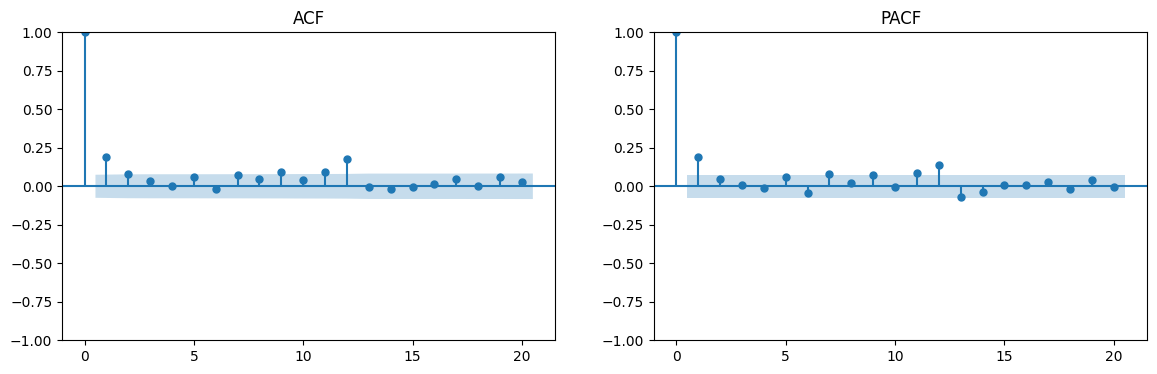

In [43]:
#ACF, PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(residuals, lags=20, ax=axes[0])
axes[0].set_title("ACF")

plot_pacf(residuals, lags=20, ax=axes[1], method="ywm")  # "ywm" ist stabil bei kurzen Reihen
axes[1].set_title("PACF")

Values do not match the theory. New approach by using North-America Data from Kenneth R. French

In [110]:
#Preparation of Data for usage
factors_us = pd.read_csv("Data/North_America_3_Factors.csv", index_col="Date")
momentum_us = pd.read_csv('Data/North_America_MOM_Factor.csv', index_col='Date')
momentum_us.index = pd.to_datetime(momentum_us.index.astype(str), format='%Y%m')
momentum_us.index = momentum_us.index.to_period('M')
factors_us.index = pd.to_datetime(factors_us.index.astype(str), format='%Y%m')
factors_us.index = factors_us.index.to_period('M')
momentum.tail()
factors_us = factors_us/100
momentum_us = momentum_us/100

df_us = pd.merge(returns, factors_us, on="Date")
df_us = pd.merge(df_us, momentum_us, on="Date")
df_us["LS-RF"] = df.long_short_ret - df.RF
RF = factors['RF']
pd.to_pickle(RF, "RF.pkl")
df_us.tail()

,long_short_ret,Mkt-RF,SMB,HML,RF,Momentum,LS-RF
Date,,,,,,,
2018-02,-0.001483,-0.0395,-0.0014,-0.0274,0.0011,0.0364,-0.002583
2018-03,0.018226,-0.0217,0.0319,0.0016,0.0012,-0.0123,0.017026
2018-04,0.011251,0.0035,0.0034,0.0136,0.0014,0.0051,0.009851
2018-05,-0.026924,0.0251,0.0344,-0.0341,0.0014,0.0400,-0.028324
2018-06,-0.008661,0.0039,0.0015,-0.0104,0.0014,-0.0130,-0.010061


In [124]:
#RF FFC

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

# Example: X = features (factors), Y = target (LS-RF excess return)
X = df_us[["Mkt-RF", "SMB", "HML", ' Momentum']]  # your features
X = sm.add_constant(X)
Y = df_us["LS-RF"]

# Fit Random Forest
regr = RandomForestRegressor(n_estimators=100, random_state=42)
regr.fit(X, Y)

# Predictions
Y_pred = regr.predict(X)

# Feature importances (normalized to sum to 1)
importances = regr.feature_importances_
importances_series = pd.Series(importances, index=X.columns)

# Compute pseudo-betas
pseudo_betas = {}
for feature in X.columns:
    # Avoid divide-by-zero by adding a small epsilon
    ratio = Y_pred / (X[feature] + 1e-8)
    elasticity = ratio * importances_series[feature]
    pseudo_betas[feature] = np.median(elasticity)  # or .median()

# Create readable result
pseudo_betas_df = pd.Series(pseudo_betas, name="Pseudo-Beta")
print("===============================================")
print("Random Forest on Fama-French-Carhart Model")
print("===============================================")
print(pseudo_betas_df)
print("-----------------------------------------------")
print("R-squared: ",regr.score(X, Y))
pseudo_alpha = np.mean(regr.predict(X))
print("-----------------------------------------------")
print("Pseudo-Alpha: ", pseudo_alpha)

print("-----------------------------------------------")
residuals = Y - regr.predict(X)
pseudo_alpha_implied = np.mean(residuals)
print("Implied Alpha: ", pseudo_alpha_implied)
print("===============================================")

Random Forest on Fama-French-Carhart Model
const        0.000000
Mkt-RF      -0.042905
SMB         -0.044383
HML          0.267168
 Momentum   -0.016478
Name: Pseudo-Beta, dtype: float64
-----------------------------------------------
R-squared:  0.9487467364240048
-----------------------------------------------
Pseudo-Alpha:  0.001558408967780993
-----------------------------------------------
Implied Alpha:  -0.00014132928302535536


In [115]:
#OLS FFC
import statsmodels.api as sm
X = df_us[["Mkt-RF", "SMB", "HML", ' Momentum']]  
X = sm.add_constant(X)
Y = df_us["LS-RF"]

model = sm.OLS(Y, X)
results = model.fit(cov_type="HC3")
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  LS-RF   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     46.73
Date:                Tue, 17 Jun 2025   Prob (F-statistic):           4.79e-31
Time:                        13:59:21   Log-Likelihood:                 871.78
No. Observations:                 332   AIC:                            -1734.
Df Residuals:                     327   BIC:                            -1715.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.001      1.272      0.2